So the first aim is to import the merged_data from agg schema and then create calendar variables and net load

In [2]:
#use my.env to connect to postgresql database usign engine
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
#connect to database
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")
from sqlalchemy import create_engine
#i will use the create_engine function to connect to the database
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')
#i will use the read_sql function to read the data from the database
df = pd.read_sql('SELECT * FROM agg.merged_data', engine)

In [3]:
#now can check df and see what work is needed
df.columns

Index(['site', 'year', 'month', 'day', 'hour', 'min', 'tz', 'soc',
       'discharge_wh', 'charge_wh', 'production_wh', 'consumption_wh',
       'gridexport_wh', 'gridimport_wh', 'pvcharge_wh', 'pvcons_wh',
       'pvexport_wh', 'griddischarge_wh', 'gridcharge_wh', 'gridcons_wh',
       'consdischarge_wh', 'mismatch_wh', 'ts', 'postcode', 'precipitation',
       'precipitation_probability', 'wind_direction', 'wind_speed',
       'solar_radiation', 'sunshine_duration', 'pred_consumption',
       'pred_production'],
      dtype='object')

In [4]:
#now want to add day_of_week, season  columns to the dataframe and net_load
df['ts']= pd.to_datetime(df['ts'])
#day of week as a number
df['day_of_week'] = df['ts'].dt.dayofweek
df['season'] = (df['ts'].dt.month%12 + 3)//3 
df['net_load'] =df['consumption_wh'] + df['charge_wh'] - df['production_wh'] - df['discharge_wh']
#set the ts as the datetime index
df.set_index('ts', inplace=True)
df_new = df

Now import weather data

In [5]:
#read in t_weather data
df_weather = pd.read_sql('SELECT * FROM agg.t_weather', engine)
df_meta_data = pd.read_sql('SELECT * FROM agg.t_meta_data_wide_format', engine)

#create a new column which is forecast_date with forecast_hour
df_weather['forecast_date'] = pd.to_datetime(df_weather['forecast_date'])
df_weather['forecast_hour'] = df_weather['forecast_hour'].astype(str)
df_weather['forecast_hour'] = df_weather['forecast_hour'].str.zfill(2)
df_weather['forecast_date'] = df_weather['forecast_date'].astype(str)
df_weather['forecast_date'] = df_weather['forecast_date'] + ' ' + df_weather['forecast_hour'] 
df_weather.tail()


,postcode,created_ts,forecast_date,forecast_hour,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,site
244123,TR4,2020-03-29 05:06:16,2020-03-29 23,23,0.0,1.0,49,14.0,0.0,0.0,"{58,62,80,84}"
244124,TR5,2020-03-29 05:06:17,2020-03-29 23,23,0.0,1.0,49,14.0,0.0,0.0,"{71,86,87,99}"
244125,TR7,2020-03-29 05:05:07,2020-03-29 23,23,0.0,1.0,44,14.0,0.0,0.0,"{4,13,56,63,69,92,95}"
244126,TR8,2020-03-29 05:05:03,2020-03-29 23,23,0.0,1.0,44,14.0,0.0,0.0,"{21,22}"
244127,TR9,2020-03-29 05:05:08,2020-03-29 23,23,0.0,1.0,44,14.0,0.0,0.0,"{6,34,50,65}"


The problem is i want to join df_new and df_weather, by matching for postcode and for that time stamp. There is definitely a better way, but traditional merge was playing up, so one way i used was to create a unique identifier which is a column which includes forecast_date + postcode in both df_new and df_weather, which allowed them to be joined.

In [6]:
#from df_nenw drop 'soc', 'discharge_wh', 'charge_wh', 'production_wh', 'consumption_wh', 'gridexport_wh', 'gridimport_wh', 'pvcharge_wh', 'pvcons_wh',
# 'pvexport_wh', 'griddischarge_wh', 'gridcharge_wh', 'gridcons_wh', 'consdischarge_wh', 'mismatch_wh', 'precipitation','precipitation_probability', 'wind_direction', 'wind_speed', 'solar_radiation', 'sunshine_duration', 'pred_consumption','pred_production',
df_new.drop(['soc','postcode','discharge_wh', 'charge_wh', 'production_wh', 'consumption_wh', 'gridexport_wh', 'gridimport_wh', 'pvcharge_wh', 'pvcons_wh',
    'pvexport_wh', 'griddischarge_wh', 'gridcharge_wh', 'gridcons_wh', 'consdischarge_wh', 'mismatch_wh', 'precipitation','precipitation_probability', 'wind_direction', 'wind_speed', 'solar_radiation', 'sunshine_duration', 'pred_consumption','pred_production'], axis=1, inplace=True)

In [7]:
#in df_new, create forecast_date column which is year-mont-day hour
df_new['forecast_date'] = df_new['year'].astype(str) + '-' + df_new['month'].astype(str).str.zfill(2) +'-' + df_new['day'].astype(str).str.zfill(2) +' '+ df_new['hour'].astype(str).str.zfill(2)
df_new.head()


,site,year,month,day,hour,min,tz,day_of_week,season,net_load,forecast_date
ts,,,,,,,,,,,
2019-08-06 04:15:00,94,2019,8,6,5,15,UTC+01:00,1,3,7.45,2019-08-06 05
2019-08-06 04:15:00,98,2019,8,6,5,15,UTC+01:00,1,3,6.03,2019-08-06 05
2019-08-06 04:15:00,100,2019,8,6,5,15,UTC+01:00,1,3,49.98,2019-08-06 05
2019-08-06 04:30:00,2,2019,8,6,5,30,UTC+01:00,1,3,8.48,2019-08-06 05
2019-08-06 04:30:00,3,2019,8,6,5,30,UTC+01:00,1,3,74.55,2019-08-06 05


In [8]:
df_new = df_new.merge(df_meta_data[['newsite', 'postcode_x']], left_on='site', right_on='newsite', how='left')
df_new.rename(columns={'postcode_x': 'postcode'}, inplace=True)
df_new.drop('newsite', axis=1, inplace=True)

In [9]:
#create column in df_new which is forecast_date plus postcode as a string
df_new['identifier'] = df_new['forecast_date'] + '' + df_new['postcode']
df_weather['identifier'] = df_weather['forecast_date'] + ' ' + df_weather['postcode']
df_weather['identifier'] = df_weather['identifier'].str.strip()
df_new['identifier'] = df_new['identifier'].str.strip() 
df_weather.head()   


,postcode,created_ts,forecast_date,forecast_hour,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,site,identifier
0,PL12,2019-03-23 00:11:24,2019-03-22 00,00,0.0,9.0,151,8.0,0.0,0.0,"{7,44,47,60}",2019-03-22 00 PL12
1,PL14,2019-03-23 00:10:49,2019-03-22 00,00,0.0,100.0,161,7.0,0.0,0.0,"{33,35}",2019-03-22 00 PL14
2,PL15,2019-03-23 00:10:46,2019-03-22 00,00,0.0,60.0,175,6.0,0.0,0.0,{28},2019-03-22 00 PL15
3,PL17,2019-03-23 00:11:21,2019-03-22 00,00,0.0,9.0,151,8.0,0.0,0.0,{45},2019-03-22 00 PL17
4,PL24,2019-03-23 00:11:23,2019-03-22 00,00,0.0,100.0,170,6.0,0.0,0.0,"{49,52}",2019-03-22 00 PL24


But the new problem was that this had many NAs when i tried that. So i have come back retrospectively,  to import data on postcodes and longitude and latitutde, to find the centroid of each postcode to find the nearest postcode.

In [10]:
#read in data files/ukpostcodes.csv
df_new['postcode'] = df_new['postcode'].str.replace(' ', '')
unique_postcodes= df_new['postcode'].unique()
df_postcodes = pd.read_csv('data files/ukpostcodes.csv')
#create district coluumn which is first part of postcode before space
df_postcodes['district'] = df_postcodes['postcode'].str.split(' ').str[0]
df_postcodes.head()

,id,postcode,latitude,longitude,district
0,1,AB10 1XG,57.144165,-2.114848,AB10
1,2,AB10 6RN,57.137880,-2.121487,AB10
2,3,AB10 7JB,57.124274,-2.127190,AB10
3,4,AB11 5QN,57.142701,-2.093295,AB11
4,5,AB11 6UL,57.137547,-2.112233,AB11


In [12]:
#create avg lon and lat column for each district
df_postcodes_grouped = df_postcodes.groupby('district').agg({'longitude': 'mean', 'latitude': 'mean'}).reset_index()
df_postcodes_grouped.head()
#filter  for only the unique postcodes
df_postcodes_grouped = df_postcodes_grouped[df_postcodes_grouped['district'].isin(unique_postcodes)]
df_postcodes_grouped.head()

#for each district, add a column which is nearest_district based on the distance between the two districts
from scipy.spatial import distance
import numpy as np
# Create a distance matrix
distance_matrix = distance.cdist(df_postcodes_grouped[['longitude', 'latitude']], df_postcodes_grouped[['longitude', 'latitude']], 'euclidean')

# Set the diagonal to infinity so that the district is not closest to itself
np.fill_diagonal(distance_matrix, np.inf)

# Find the index of the nearest districts
nearest_district_indices = np.argsort(distance_matrix, axis=1)[:, :10]
# Find the index of the nearest districts
nearest_district_indices = np.argsort(distance_matrix, axis=1)[:, :10]

# Get the district names of the nearest districts
nearest_district_columns = ['nearest_district_1', 'nearest_district_2', 'nearest_district_3', 'nearest_district_4','nearest_district_5',
                            'nearest_district_6','nearest_district_7','nearest_district_8','nearest_district_9','nearest_district_10']     # i am trying to find the nearest 10 districts - i.e. if using the first neaaret there are still na, try district 2.

for i, col in enumerate(nearest_district_columns):
    df_postcodes_grouped[col] = df_postcodes_grouped['district'].iloc[nearest_district_indices[:, i]].values

# Merge with the main DataFrame
df_new = df_new.merge(df_postcodes_grouped[['district'] + nearest_district_columns], left_on='postcode', right_on='district', how='left')

# Create identifiers for the 1st to 4th closest districts
for i, col in enumerate(nearest_district_columns, start=1):
    df_new['identifier_' + str(i)] = df_new['forecast_date'] + ' ' + df_new[col]

# Strip whitespace from identifiers
for i in range(1, 11):
    df_new['identifier_' + str(i)] = df_new['identifier_' + str(i)].str.strip()

# Display the DataFrame
df_new.head()




,site,year,month,day,hour,min,tz,day_of_week,season,net_load,...,identifier_1,identifier_2,identifier_3,identifier_4,identifier_5,identifier_6,identifier_7,identifier_8,identifier_9,identifier_10
0,94,2019,8,6,5,15,UTC+01:00,1,3,7.45,...,2019-08-06 05 PL24,2019-08-06 05 TR9,2019-08-06 05 PL31,2019-08-06 05 PL27,2019-08-06 05 PL30,2019-08-06 05 TR8,2019-08-06 05 TR1,2019-08-06 05 TR3,2019-08-06 05 TR4,2019-08-06 05 TR11
1,98,2019,8,6,5,15,UTC+01:00,1,3,6.03,...,2019-08-06 05 TR11,2019-08-06 05 TR4,2019-08-06 05 TR1,2019-08-06 05 TR16,2019-08-06 05 TR14,2019-08-06 05 TR8,2019-08-06 05 TR9,2019-08-06 05 TR27,2019-08-06 05 PL26,2019-08-06 05 TR26
2,100,2019,8,6,5,15,UTC+01:00,1,3,49.98,...,2019-08-06 05 PL24,2019-08-06 05 TR9,2019-08-06 05 PL31,2019-08-06 05 PL27,2019-08-06 05 PL30,2019-08-06 05 TR8,2019-08-06 05 TR1,2019-08-06 05 TR3,2019-08-06 05 TR4,2019-08-06 05 TR11
3,2,2019,8,6,5,30,UTC+01:00,1,3,8.48,...,2019-08-06 05 TR9,2019-08-06 05 PL30,2019-08-06 05 PL31,2019-08-06 05 PL26,2019-08-06 05 TR8,2019-08-06 05 PL24,2019-08-06 05 TR1,2019-08-06 05 TR4,2019-08-06 05 TR3,2019-08-06 05 PL14
4,3,2019,8,6,5,30,UTC+01:00,1,3,74.55,...,2019-08-06 05 PL31,2019-08-06 05 PL24,2019-08-06 05 PL27,2019-08-06 05 PL26,2019-08-06 05 TR9,2019-08-06 05 PL14,2019-08-06 05 TR8,2019-08-06 05 PL15,2019-08-06 05 TR1,2019-08-06 05 TR4


In [13]:
df_new.columns

Index(['site', 'year', 'month', 'day', 'hour', 'min', 'tz', 'day_of_week',
       'season', 'net_load', 'forecast_date', 'postcode', 'identifier',
       'district', 'nearest_district_1', 'nearest_district_2',
       'nearest_district_3', 'nearest_district_4', 'nearest_district_5',
       'nearest_district_6', 'nearest_district_7', 'nearest_district_8',
       'nearest_district_9', 'nearest_district_10', 'identifier_1',
       'identifier_2', 'identifier_3', 'identifier_4', 'identifier_5',
       'identifier_6', 'identifier_7', 'identifier_8', 'identifier_9',
       'identifier_10'],
      dtype='object')

Now merge df_new and df_weather on the identifier, and then loop through if nas to try the next nearest identifier to fillna.

In [14]:
#now i want to add the weather data to the df_new dataframe, aadding the weather data based on identifier 
df_joined = df_new.merge(df_weather, on='identifier', how='left')
df_joined.head()
#sum null values in each column
df_joined.isnull().sum()

#for identifier 1 to 10, create df_joined_merged which is the merge of df_new and df_weather on identifier and then replace null values in df_joined with the weather data
for i in range(1, 11):
    df_joined_merged = pd.merge(df_new, df_weather, left_on='identifier_' + str(i), right_on='identifier', how='left')
    df_joined['precipitation'].fillna(df_joined_merged['precipitation'], inplace=True)
    df_joined['precipitation_probability'].fillna(df_joined_merged['precipitation_probability'], inplace=True)
    df_joined['wind_direction'].fillna(df_joined_merged['wind_direction'], inplace=True)
    df_joined['wind_speed'].fillna(df_joined_merged['wind_speed'], inplace=True)
    df_joined['solar_radiation'].fillna(df_joined_merged['solar_radiation'], inplace=True)
    df_joined['sunshine_duration'].fillna(df_joined_merged['sunshine_duration'], inplace=True)

df_joined.head()
df_joined.isnull().sum()


/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1040552356.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_joined['precipitation'].fillna(df_joined_merged['precipitation'], inplace=True)
/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1040552356.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object

site_x                            0
year                              0
month                             0
day                               0
hour                              0
min                               0
tz                                0
day_of_week                       0
season                            0
net_load                          0
forecast_date_x                   0
postcode_x                        0
identifier                        0
district                      38099
nearest_district_1            38099
nearest_district_2            38099
nearest_district_3            38099
nearest_district_4            38099
nearest_district_5            38099
nearest_district_6            38099
nearest_district_7            38099
nearest_district_8            38099
nearest_district_9            38099
nearest_district_10           38099
identifier_1                  38099
identifier_2                  38099
identifier_3                  38099
identifier_4                

In [15]:
df_joined['precipitation'].isnull().sum()    #so by using the 5 nearest sites, have gone frm 260,000 nulls to 156,000 nulls  - not perfect but can do some further investigation

156118

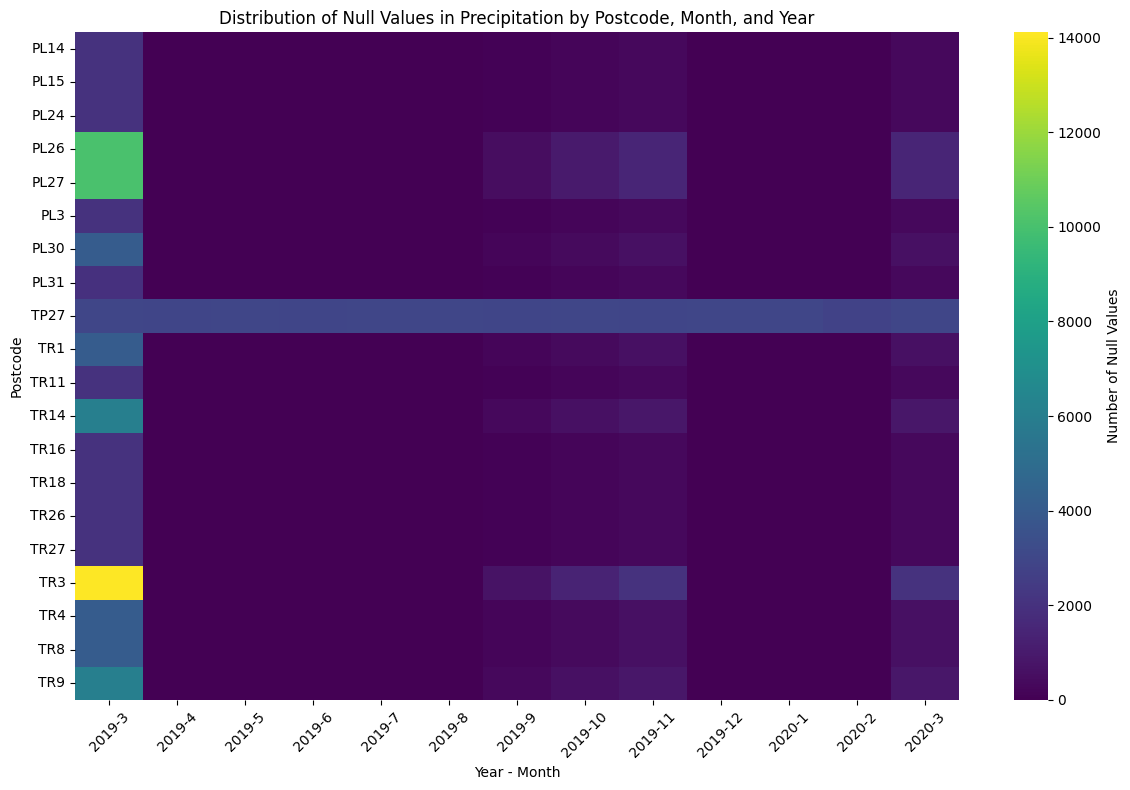

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
#want to see distribution of precipitation nulls by district, month/year, etc
nulls_pivot = df_joined.pivot_table(index='postcode_x', columns=['year', 'month'], values='precipitation', aggfunc=lambda x: x.isnull().sum())

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(nulls_pivot, cmap='viridis', cbar_kws={'label': 'Number of Null Values'})
plt.title('Distribution of Null Values in Precipitation by Postcode, Month, and Year')
plt.xlabel('Year - Month')
plt.ylabel('Postcode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


So the reason that find nearest postcode stops working after a given point is that the bulk of missingvalues are in 2019-3 - the first month, where clearly it looks for the nearest which also has many missing values. Foro example, if i sum the missing values after applying nearest postcode inn the month 2019-3, we can see the missing values are predominantly from month 2019-3;see below - 86,000!

In [17]:
#sum nan values for precipitation in 2019-3
df_joined[(df_joined['year'] == 2019) & (df_joined['month'] == 3)]['precipitation'].isnull().sum()

85567

In [18]:
df_joined.columns

Index(['site_x', 'year', 'month', 'day', 'hour', 'min', 'tz', 'day_of_week',
       'season', 'net_load', 'forecast_date_x', 'postcode_x', 'identifier',
       'district', 'nearest_district_1', 'nearest_district_2',
       'nearest_district_3', 'nearest_district_4', 'nearest_district_5',
       'nearest_district_6', 'nearest_district_7', 'nearest_district_8',
       'nearest_district_9', 'nearest_district_10', 'identifier_1',
       'identifier_2', 'identifier_3', 'identifier_4', 'identifier_5',
       'identifier_6', 'identifier_7', 'identifier_8', 'identifier_9',
       'identifier_10', 'postcode_y', 'created_ts', 'forecast_date_y',
       'forecast_hour', 'precipitation', 'precipitation_probability',
       'wind_direction', 'wind_speed', 'solar_radiation', 'sunshine_duration',
       'site_y'],
      dtype='object')

So i will now tidy up and upload to sql - still have 160,000 NAs but will discuss at next meeting

In [19]:
#drop site_y, postcode_y, forecast_date_y, forecast_hour,created_ts, forecast_date_x, postcode_x,identifier
df_joined_clean = df_joined[["site_x","year","month","day","hour","min","tz","day_of_week","season","net_load","precipitation","precipitation_probability","wind_direction","wind_speed","solar_radiation","sunshine_duration"]]
#rename site_x to site
df_joined_clean.rename(columns={'site_x': 'site'}, inplace=True)
df_joined_clean.head()




/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/2201044116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean.rename(columns={'site_x': 'site'}, inplace=True)


,site,year,month,day,hour,min,tz,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration
0,94,2019,8,6,5,15,UTC+01:00,1,3,7.45,0.0,9.0,206,11.0,0.0,0.0
1,98,2019,8,6,5,15,UTC+01:00,1,3,6.03,0.0,8.0,215,12.0,0.0,0.0
2,100,2019,8,6,5,15,UTC+01:00,1,3,49.98,0.0,9.0,206,11.0,0.0,0.0
3,2,2019,8,6,5,30,UTC+01:00,1,3,8.48,0.0,9.0,206,11.0,0.0,0.0
4,3,2019,8,6,5,30,UTC+01:00,1,3,74.55,0.0,9.0,206,11.0,0.0,0.0


In [20]:
import pytz
df_joined_clean['tz_offset'] = df_joined_clean['tz'].str.extract(r'UTC\+(\d+):(\d+)')[0].astype(int) * 60 + df_joined_clean['tz'].str.extract(r'UTC\+(\d+):(\d+)')[1].astype(int)
df_joined_clean['timestamp'] = df_joined_clean.apply(lambda row: f"{row['year']}-{row['month']:02d}-{row['day']:02d} {row['hour']:02d}:{row['min']:02d}:00", axis=1)
df_joined_clean['timestamp'] = pd.to_datetime(df_joined_clean['timestamp'])
df_joined_clean['timestamp'] = df_joined_clean['timestamp'].dt.tz_localize(pytz.FixedOffset(int(df_joined_clean['tz_offset'].iloc[0])))

# Set the timestamp column as the index
df_joined_clean.set_index('timestamp', inplace=True)
df_joined_clean.head()


/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1999479309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean['tz_offset'] = df_joined_clean['tz'].str.extract(r'UTC\+(\d+):(\d+)')[0].astype(int) * 60 + df_joined_clean['tz'].str.extract(r'UTC\+(\d+):(\d+)')[1].astype(int)
/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1999479309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean['timestamp'] = df_joined_clean.apply(lambda row: f"{row['year'

,site,year,month,day,hour,min,tz,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,tz_offset
timestamp,,,,,,,,,,,,,,,,,
2019-08-06 05:15:00+01:00,94,2019,8,6,5,15,UTC+01:00,1,3,7.45,0.0,9.0,206,11.0,0.0,0.0,60
2019-08-06 05:15:00+01:00,98,2019,8,6,5,15,UTC+01:00,1,3,6.03,0.0,8.0,215,12.0,0.0,0.0,60
2019-08-06 05:15:00+01:00,100,2019,8,6,5,15,UTC+01:00,1,3,49.98,0.0,9.0,206,11.0,0.0,0.0,60
2019-08-06 05:30:00+01:00,2,2019,8,6,5,30,UTC+01:00,1,3,8.48,0.0,9.0,206,11.0,0.0,0.0,60
2019-08-06 05:30:00+01:00,3,2019,8,6,5,30,UTC+01:00,1,3,74.55,0.0,9.0,206,11.0,0.0,0.0,60


In [21]:
# Drop the columns that were used to create the timestamp
df_joined_clean.drop(columns=['tz','tz_offset'], inplace=True)
df_joined_clean.head()

/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/130264195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean.drop(columns=['tz','tz_offset'], inplace=True)


,site,year,month,day,hour,min,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration
timestamp,,,,,,,,,,,,,,,
2019-08-06 05:15:00+01:00,94,2019,8,6,5,15,1,3,7.45,0.0,9.0,206,11.0,0.0,0.0
2019-08-06 05:15:00+01:00,98,2019,8,6,5,15,1,3,6.03,0.0,8.0,215,12.0,0.0,0.0
2019-08-06 05:15:00+01:00,100,2019,8,6,5,15,1,3,49.98,0.0,9.0,206,11.0,0.0,0.0
2019-08-06 05:30:00+01:00,2,2019,8,6,5,30,1,3,8.48,0.0,9.0,206,11.0,0.0,0.0
2019-08-06 05:30:00+01:00,3,2019,8,6,5,30,1,3,74.55,0.0,9.0,206,11.0,0.0,0.0


In [22]:
#create the avg_net_load column
df_joined_clean['avg_net_load'] = df_joined_clean.groupby('timestamp')['net_load'].transform('mean')
#only have 2 decimal places for the avg_net_load
df_joined_clean['avg_net_load'] = df_joined_clean['avg_net_load'].round(2)
#do a column which is 25% quantile, 75% quantile, and median for that timestamp
df_joined_clean['q25_net_load'] = df_joined_clean.groupby('timestamp')['net_load'].transform(lambda x: x.quantile(0.25))
df_joined_clean['q75_net_load'] = df_joined_clean.groupby('timestamp')['net_load'].transform(lambda x: x.quantile(0.75))
df_joined_clean['median_net_load'] = df_joined_clean.groupby('timestamp')['net_load'].transform('median')
#create a column which is a weekend or bank holiday = 1 or not
import holidays
uk_holidays = holidays.UnitedKingdom(years=df_joined_clean.index.year.unique())
df_joined_clean['is_weekend'] = df_joined_clean['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df_joined_clean['is_weekend'] = df_joined_clean.index.dayofweek.isin([5, 6]).astype(int)

# Create a column indicating whether a date is a bank holiday
df_joined_clean['is_bank_holiday'] = df_joined_clean.index.isin(uk_holidays.keys()).astype(int)
# Combine the two flags to get a single column indicating weekend or bank holiday
df_joined_clean['weekend_or_bank_holiday'] = df_joined_clean['is_weekend'] | df_joined_clean['is_bank_holiday']
df_joined_clean = df_joined_clean.drop(columns=['is_weekend', 'is_bank_holiday'])
df_joined_clean.head()

/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1926528495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean['avg_net_load'] = df_joined_clean.groupby('timestamp')['net_load'].transform('mean')
/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1926528495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined_clean['avg_net_load'] = df_joined_clean['avg_net_load'].round(2)
/var/folders/xj/l3ddnb5x07zcwskyq78r9l_40000gn/T/ipykernel_15465/1926528495.py:6

,site,year,month,day,hour,min,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,
2019-08-06 05:15:00+01:00,94,2019,8,6,5,15,1,3,7.45,0.0,9.0,206,11.0,0.0,0.0,44.00,6.84,51.2450,7.925,0
2019-08-06 05:15:00+01:00,98,2019,8,6,5,15,1,3,6.03,0.0,8.0,215,12.0,0.0,0.0,44.00,6.84,51.2450,7.925,0
2019-08-06 05:15:00+01:00,100,2019,8,6,5,15,1,3,49.98,0.0,9.0,206,11.0,0.0,0.0,44.00,6.84,51.2450,7.925,0
2019-08-06 05:30:00+01:00,2,2019,8,6,5,30,1,3,8.48,0.0,9.0,206,11.0,0.0,0.0,36.16,7.19,55.4525,8.140,0
2019-08-06 05:30:00+01:00,3,2019,8,6,5,30,1,3,74.55,0.0,9.0,206,11.0,0.0,0.0,36.16,7.19,55.4525,8.140,0


In [23]:
#now upload to postgresql server 
df_joined_clean.to_sql('tidy_data', engine, if_exists='replace',schema='agg')

402